# Inteligência Artificial Aplicada a Finanças

# Projeto 4 - Automatizando Auditoria Financeira e Contábil com IA

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.7.6


![title](imagens/projeto4.png)

## Definindo o Problema

Neste projeto vamos construir uma aplicação para executar auditoria financeira e contábil. Nossa aplicação vai buscar por um tipo específico de crime, conhecido como SMURF, usado em lavagem de dinheiro.

Para conhecer mais sobre esse tipo de crime, confira aqui: https://www.investopedia.com/terms/s/smurf.asp

O trabalho está divivido em duas partes. Na parte 1 vamos gerar as anomalias com um padrão comum em crimes de lavagem de dinheiro e na parte 2 vamos buscar e detectar essas anomalias.

## Fonte de Dados

<a href="https://data.world/lpetrocelli/czech-financial-dataset-real-anonymized-transactions">1999 Czech Financial Dataset - Real Anonymized Transactions</a>

### Instalando e Carregando Pacotes

In [2]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark.
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
#!pip install -q -U watermark

In [3]:
# Imports
import copy
import scipy
import pickle
import argparse
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from math import ceil
from collections import OrderedDict
from joblib import Parallel, delayed
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

numpy      1.18.5
scipy      1.4.1
matplotlib 3.3.1
pandas     1.1.4
argparse   1.1
Data Science Academy


## Carrega os Dados

In [5]:
# Carrega o dataset
df = pd.read_csv('dados/raw_cfd_trans.csv', sep = ';', usecols = [1, 2, 4, 5, 9])

In [6]:
df.head()

,account_id,date,operation,amount,account
0,2378,930101,VKLAD,700.0,NaN
1,576,930101,VKLAD,900.0,NaN
2,704,930101,VKLAD,1000.0,NaN
3,3818,930101,VKLAD,600.0,NaN
4,1972,930102,VKLAD,400.0,NaN


In [7]:
df.shape

(1056320, 5)

### Parte 1 - Geração de Anomalias nos Dados

In [8]:
# Função para embaralhar os dados no padrão de uma técnica de lavagem de dinheiro chamada SMURF
def gera_novos_dados(el, bank_acc, client_acc, middle_num, folds = 10, seed = 0):
    
    # Random seed
    np.random.seed(seed)
    
    # Lista
    evaluate = []
    
    # Loop pelos folds
    for _ in range(folds):
        
        # Escolha aleatória
        src, dst = np.random.choice(client_acc, 2)
        middle_acc = np.random.choice(bank_acc, middle_num)
        edgelist = copy.copy(el)

        # Loop
        for mcc in middle_acc:
            edgelist.add((src, mcc))
            edgelist.add((mcc, dst))

        # Gera noise
        noise_num = np.random.randint(1, 6)
        
        # Loop
        for _ in range(noise_num):
            r = np.random.randint(11)
            mn = middle_num + (5 - r)
            n_src, n_dst = np.random.choice([ca for ca in client_acc if ca != src and ca != dst], 2)
            n_middle = np.random.choice(bank_acc, mn)
            for mcc in n_middle:
                edgelist.add((n_src, mcc))
                edgelist.add((mcc, n_dst))

                for c in n_middle:
                    # Interação entre intermediários
                    if c != mcc and np.random.randint(1, 11) > r / 2.5 + 6:
                        edgelist.add((mcc, c))

        evaluate.append({'Edgelist': edgelist, 'Label': [src, dst]})
    return evaluate

In [9]:
# Função para gerar anomalia
def gera_anomalia(file_name, interact_prob, folds = 10, seed = 0):
    
    # Seed para o processo aleatório
    np.random.seed(seed)

    # Carrega o dataframe original e remove valores NA
    dados = pd.read_csv('dados/raw_cfd_trans.csv', sep = ';', usecols = [1, 2, 4, 5, 9]).dropna()
    
    # Filtra as operações financeiras
    dados = dados[dados['operation'].isin(['PREVOD Z UCTU', 'PREVOD NA UCET'])]
    
    # Obtém os ids das contas
    bank_acc = dados['account_id'].unique().astype(int)
    client_acc = dados['account'].unique().astype(int)

    # Cria um set para as combinações que serão geradas
    edgelist = set()
    
    # Loop pelos valores
    for i in dados.values:
        if i[2] == 'PREVOD Z UCTU':
            edgelist.add((int(i[4]), int(i[0])))
        else:
            edgelist.add((int(i[0]), int(i[4])))

    for s in bank_acc:
        for d in bank_acc:
            if np.random.random() > interact_prob:
                edgelist.add((s, d))

    data = {}
    for i in range(10, 51, 10):
        data[i] = gera_novos_dados(edgelist, bank_acc, client_acc, i, folds = folds, seed = seed)

    with open(file_name + '.pkl', 'wb') as handle:
        pickle.dump(data, handle, protocol = pickle.HIGHEST_PROTOCOL)

> Agora executamos as funções para gerar a anomalia

In [10]:
if __name__ == '__main__':
    gera_anomalia('dados/novos_dados_smurf', 0.9995, 10, 0)

### Parte 2 - Detecção de Anomalias

In [11]:
# Função para o cálculo de log
def log_star(x):
    return 2 * np.log2(x) + 1

In [12]:
# Função para converter lista de vértices para matriz
def edgelist_to_matrix(edgelist):
    node_dict = {e: idx for idx, e in enumerate(np.unique(list(edgelist)))}
    ajm = np.zeros((len(node_dict), len(node_dict)))
    for e in edgelist:
        ajm[node_dict[e[0]]][node_dict[e[1]]] = 1
    return ajm, node_dict

Calcula o MDL (Minimum Description Length)

https://en.wikipedia.org/wiki/Minimum_description_length

O MDL se aplica ao aprendizado de máquina quando algoritmos geram descrições. O aprendizado ocorre quando um algoritmo gera uma descrição mais curta do mesmo conjunto de dados.

O princípio MDL é baseado no seguinte insight: qualquer regularidade em um determinado conjunto de dados pode ser usada para compactar os dados, ou seja, para descrevê-los usando menos símbolos do que o necessário para descrever os dados literalmente. 

Em sua forma mais básica, MDL é um princípio de seleção de modelo: a descrição mais curta dos dados como o melhor modelo.

Implementação do algoritmo: 

https://www.sciencedirect.com/topics/computer-science/minimum-description-length

https://homepages.cwi.nl/~pdg/ftp/mdlintro.pdf

In [13]:
# Função o cálculo de mdl
def compute_mdl(ajm, order, start, count):
    
    # Pureza e mdl
    purity, mdl, n = [], 0, len(ajm)
    order.extend([i for i in range(n) if i not in order])
    ajm = np.array(ajm)[np.ix_(order, order)]

    # Encode sub-matrix A, B e C
    for idx in range(1, len(start)):
        s, e = start[idx-1], start[idx] - 1
        k = e - s + 1
        e1 = np.sum(ajm[s+1:e, s:e-1]) * (2 * ceil(np.log2(k - 1)))
        e2 = np.sum(ajm[e+1:-1, s:e]) * (ceil(np.log2(n)) + ceil(np.log2(n - k)))
        e3 = np.sum(ajm[s:e, e+1:-1]) * (ceil(np.log2(n)) + ceil(np.log2(n - k)))
        et = e1 + e2 + e3
        mdl += et
        sum_abc = np.sum(ajm[s:e, s:e]) + np.sum(ajm[e+1:-1, s:e]) + np.sum(ajm[s:e, e+1:-1])
        purity.append((k - 2) * 2 / sum_abc)

    # Encode sub-matrix D
    ajm = 1 - ajm
    mdl += np.sum(ajm[start[-1]:-1, start[-1]:-1]) * (2 * ceil(np.log2(n)))

    # Encode do número real de padrões e intermediários encontrados
    mdl += ceil(log_star(count[0])) + ceil(log_star(count[1]))
    
    # Encode dos índices de remetentes, receptores e intermediários
    mdl += np.sum(count) * ceil(np.log2(n))
    
    # Encode para o ponto inicial de cada padrão
    mdl += ceil(log_star(len(start) - 1))

    return mdl, np.mean(purity)

In [14]:
# Função para auditoria (detecção de padrões)
def func_auditoria(ajm, max_iter, visualize):

    # Obtém pares de combinações que têm o número de intermediários maior que o limite c
    print('Obtendo Combinações de Pares...')
    row, col = ajm, ajm.T
    edis = OrderedDict()
    dis_mtr = (sparse.csr_matrix(ajm) * sparse.csr_matrix(ajm)).todense()
    
    # Loop
    for idx1, idx2 in zip(*dis_mtr.nonzero()):
        val = dis_mtr[idx1, idx2]
        if val >= 3:
            edis[(idx1, idx2)] = [val, np.arange(len(row))[(row[idx1] + col[idx2]) == 2]]
            
    edis = OrderedDict(sorted(edis.items(), key = lambda t: t[1][0])[::-1])
    print('Concluído!\n')

    # Identifica heuristicamente a melhor ordem por MDL e pureza
    print('Identificando a melhor ordem...')

    # Função
    def func(ajm, key, value, order, count, start, prev_mdl):
        if key[0] not in order and key[1] not in order:
            order.append(key[0])
            tmp_mid = [a for a in value[1] if a not in order]
            
            if len(tmp_mid) == 0:
                return -1, -1, -1, -1, -1
            
            order.extend(tmp_mid)
            order.append(key[1])
            start.append(len(order))
            
            mdl, purity = compute_mdl(ajm, 
                                      copy.copy(order), 
                                      copy.copy(start), 
                                      [count[0] + 1, count[1] + len(tmp_mid), count[2] + 1])
            
            # Calcula o score com base no mdl e pureza
            score = ((prev_mdl - mdl) / prev_mdl) * purity
            
            # Verifica se é o menor valor de mdl
            if mdl < prev_mdl:
                count = [count[0] + 1, count[1] + len(tmp_mid), count[2] + 1]
                return mdl, score, order, start, count
            
        return -1, -1, -1, -1, -1

    # Ajusta os valores
    old_mdl = np.ceil(np.sum(1 - ajm)) * (2 * ceil(np.log2(len(ajm))))
    count_arr, order_arr, start_arr, mdl_arr = [[0, 0, 0]], [[]], [[0]], [old_mdl]
    iter = 0
    
    # Loop enquanto for verdadeiro
    while True:
        
        # Obtém o mdl anterior
        prev_mdl = mdl_arr[-1]
        
        # Paraleliza a execução
        results = Parallel(n_jobs=4)([delayed(func)(ajm, 
                                                    key, 
                                                    value, 
                                                    copy.copy(order_arr[-1]), 
                                                    copy.copy(count_arr[-1]), 
                                                    copy.copy(start_arr[-1]), 
                                                    prev_mdl) for idx, (key, value) in enumerate(edis.items())])
        
        # Calcula os valores temporários
        tmp_mdl = [r[0] for r in results]
        tmp_score = [r[1] for r in results]
        tmp_order = [r[2] for r in results]
        tmp_start = [r[3] for r in results]
        tmp_count = [r[4] for r in results]

        # Verifica se ainda tem padrão SMURF nos dados
        if np.max(tmp_score) == -1 or (max_iter != None and iter > max_iter):
            break
            
        # Obtém os valores finais
        max_idx = np.argmax(tmp_score)
        count_arr.append(tmp_count[max_idx])
        order_arr.append(tmp_order[max_idx])
        start_arr.append(tmp_start[max_idx])
        mdl_arr.append(tmp_mdl[max_idx])
        iter += 1
        
    print('Concluído!\n')

    # Obtém o resultado com MDL 10% maior que os bits mínimos
    max_idx = next(idx - 1 for idx, m in enumerate(mdl_arr) if m < mdl_arr[-1] * 1.1)
    count, order, start, ori_mdl = count_arr[max_idx], order_arr[max_idx], start_arr[max_idx], mdl_arr[max_idx]
    order.extend([i for i in range(len(ajm)) if i not in order])
    ro_ajm = ajm[np.ix_(order, order)]


    if visualize != None:
        print('Visualizando o Resultado...')
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.matshow(ajm, fignum=False, cmap='binary')
        plt.title('Antes da Reordenação\n')
        plt.subplot(1, 2, 2)
        plt.matshow(ro_ajm, fignum=False, cmap='binary')
        plt.title('Depois da Reordenação\n')
        plt.show()
        print('Concluído!\n')

    return ro_ajm, order

> Agora executamos a aplicação

Obtendo Combinações de Pares...
Concluído!

Identificando a melhor ordem...
Concluído!

Visualizando o Resultado...


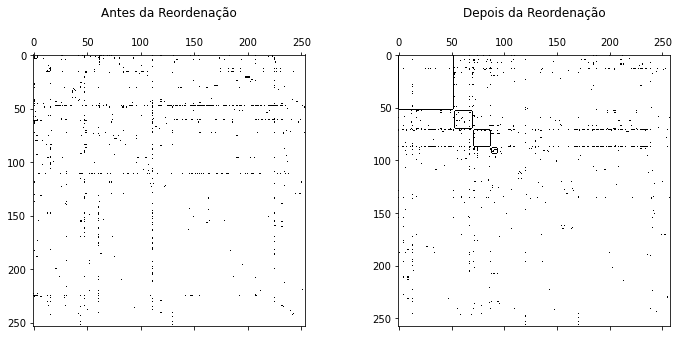

Concluído!



In [15]:
if __name__ == '__main__':
    ajm = np.loadtxt('dados/sample_matrix.txt')
    ro_ajm, order = func_auditoria(ajm, None, 'resultado/auditoria.png')

# Fim